In [1]:
import torch


class Conv2d_batchnorm(torch.nn.Module):
	'''
	2D Convolutional layers

	Arguments:
		num_in_filters {int} -- number of input filters
		num_out_filters {int} -- number of output filters
		kernel_size {tuple} -- size of the convolving kernel
		stride {tuple} -- stride of the convolution (default: {(1, 1)})
		activation {str} -- activation function (default: {'relu'})

	'''
	def __init__(self, num_in_filters, num_out_filters, kernel_size, stride = (1,1), activation = 'relu'):
		super().__init__()
		self.activation = activation
		self.conv1 = torch.nn.Conv2d(in_channels=num_in_filters, out_channels=num_out_filters, kernel_size=kernel_size, stride=stride, padding = 'same')
		self.batchnorm = torch.nn.BatchNorm2d(num_out_filters)

	def forward(self,x):
		x = self.conv1(x)
		x = self.batchnorm(x)

		if self.activation == 'relu':
			return torch.nn.functional.relu(x)
		else:
			return x


class Multiresblock(torch.nn.Module):
	'''
	MultiRes Block

	Arguments:
		num_in_channels {int} -- Number of channels coming into mutlires block
		num_filters {int} -- Number of filters in a corrsponding UNet stage
		alpha {float} -- alpha hyperparameter (default: 1.67)

	'''

	def __init__(self, num_in_channels, num_filters, alpha=1.67):

		super().__init__()
		self.alpha = alpha
		self.W = num_filters * alpha

		filt_cnt_3x3 = int(self.W*0.167)
		filt_cnt_5x5 = int(self.W*0.333)
		filt_cnt_7x7 = int(self.W*0.5)
		num_out_filters = filt_cnt_3x3 + filt_cnt_5x5 + filt_cnt_7x7

		self.shortcut = Conv2d_batchnorm(num_in_channels ,num_out_filters , kernel_size = (1,1), activation='None')

		self.conv_3x3 = Conv2d_batchnorm(num_in_channels, filt_cnt_3x3, kernel_size = (3,3), activation='relu')

		self.conv_5x5 = Conv2d_batchnorm(filt_cnt_3x3, filt_cnt_5x5, kernel_size = (3,3), activation='relu')

		self.conv_7x7 = Conv2d_batchnorm(filt_cnt_5x5, filt_cnt_7x7, kernel_size = (3,3), activation='relu')

		self.batch_norm1 = torch.nn.BatchNorm2d(num_out_filters)
		self.batch_norm2 = torch.nn.BatchNorm2d(num_out_filters)

	def forward(self,x):

		shrtct = self.shortcut(x)

		a = self.conv_3x3(x)
		b = self.conv_5x5(a)
		c = self.conv_7x7(b)

		x = torch.cat([a,b,c],axis=1)
		x = self.batch_norm1(x)

		x = x + shrtct
		x = self.batch_norm2(x)
		x = torch.nn.functional.relu(x)

		return x


class Respath(torch.nn.Module):
	'''
	ResPath

	Arguments:
		num_in_filters {int} -- Number of filters going in the respath
		num_out_filters {int} -- Number of filters going out the respath
		respath_length {int} -- length of ResPath

	'''

	def __init__(self, num_in_filters, num_out_filters, respath_length):

		super().__init__()

		self.respath_length = respath_length
		self.shortcuts = torch.nn.ModuleList([])
		self.convs = torch.nn.ModuleList([])
		self.bns = torch.nn.ModuleList([])

		for i in range(self.respath_length):
			if(i==0):
				self.shortcuts.append(Conv2d_batchnorm(num_in_filters, num_out_filters, kernel_size = (1,1), activation='None'))
				self.convs.append(Conv2d_batchnorm(num_in_filters, num_out_filters, kernel_size = (3,3),activation='relu'))


			else:
				self.shortcuts.append(Conv2d_batchnorm(num_out_filters, num_out_filters, kernel_size = (1,1), activation='None'))
				self.convs.append(Conv2d_batchnorm(num_out_filters, num_out_filters, kernel_size = (3,3), activation='relu'))

			self.bns.append(torch.nn.BatchNorm2d(num_out_filters))


	def forward(self,x):

		for i in range(self.respath_length):

			shortcut = self.shortcuts[i](x)

			x = self.convs[i](x)
			x = self.bns[i](x)
			x = torch.nn.functional.relu(x)

			x = x + shortcut
			x = self.bns[i](x)
			x = torch.nn.functional.relu(x)

		return x


class MultiResUnet(torch.nn.Module):
	'''
	MultiResUNet

	Arguments:
		input_channels {int} -- number of channels in image
		num_classes {int} -- number of segmentation classes
		alpha {float} -- alpha hyperparameter (default: 1.67)

	Returns:
		[keras model] -- MultiResUNet model
	'''
	def __init__(self, input_channels, num_classes, alpha=1.67):
		super().__init__()

		self.alpha = alpha

		# Encoder Path
		self.multiresblock1 = Multiresblock(input_channels,32)
		self.in_filters1 = int(32*self.alpha*0.167)+int(32*self.alpha*0.333)+int(32*self.alpha* 0.5)
		self.pool1 =  torch.nn.MaxPool2d(2)
		self.respath1 = Respath(self.in_filters1,32,respath_length=4)

		self.multiresblock2 = Multiresblock(self.in_filters1,32*2)
		self.in_filters2 = int(32*2*self.alpha*0.167)+int(32*2*self.alpha*0.333)+int(32*2*self.alpha* 0.5)
		self.pool2 =  torch.nn.MaxPool2d(2)
		self.respath2 = Respath(self.in_filters2,32*2,respath_length=3)


		self.multiresblock3 =  Multiresblock(self.in_filters2,32*4)
		self.in_filters3 = int(32*4*self.alpha*0.167)+int(32*4*self.alpha*0.333)+int(32*4*self.alpha* 0.5)
		self.pool3 =  torch.nn.MaxPool2d(2)
		self.respath3 = Respath(self.in_filters3,32*4,respath_length=2)


		self.multiresblock4 = Multiresblock(self.in_filters3,32*8)
		self.in_filters4 = int(32*8*self.alpha*0.167)+int(32*8*self.alpha*0.333)+int(32*8*self.alpha* 0.5)
		self.pool4 =  torch.nn.MaxPool2d(2)
		self.respath4 = Respath(self.in_filters4,32*8,respath_length=1)


		self.multiresblock5 = Multiresblock(self.in_filters4,32*16)
		self.in_filters5 = int(32*16*self.alpha*0.167)+int(32*16*self.alpha*0.333)+int(32*16*self.alpha* 0.5)

		# Decoder path
		self.upsample6 = torch.nn.ConvTranspose2d(self.in_filters5,32*8,kernel_size=(2,2),stride=(2,2))
		self.concat_filters1 = 32*8 *2
		self.multiresblock6 = Multiresblock(self.concat_filters1,32*8)
		self.in_filters6 = int(32*8*self.alpha*0.167)+int(32*8*self.alpha*0.333)+int(32*8*self.alpha* 0.5)

		self.upsample7 = torch.nn.ConvTranspose2d(self.in_filters6,32*4,kernel_size=(2,2),stride=(2,2))
		self.concat_filters2 = 32*4 *2
		self.multiresblock7 = Multiresblock(self.concat_filters2,32*4)
		self.in_filters7 = int(32*4*self.alpha*0.167)+int(32*4*self.alpha*0.333)+int(32*4*self.alpha* 0.5)

		self.upsample8 = torch.nn.ConvTranspose2d(self.in_filters7,32*2,kernel_size=(2,2),stride=(2,2))
		self.concat_filters3 = 32*2 *2
		self.multiresblock8 = Multiresblock(self.concat_filters3,32*2)
		self.in_filters8 = int(32*2*self.alpha*0.167)+int(32*2*self.alpha*0.333)+int(32*2*self.alpha* 0.5)

		self.upsample9 = torch.nn.ConvTranspose2d(self.in_filters8,32,kernel_size=(2,2),stride=(2,2))
		self.concat_filters4 = 32 *2
		self.multiresblock9 = Multiresblock(self.concat_filters4,32)
		self.in_filters9 = int(32*self.alpha*0.167)+int(32*self.alpha*0.333)+int(32*self.alpha* 0.5)

		self.conv_final = Conv2d_batchnorm(self.in_filters9, 1, kernel_size = (1,1), activation='None')

	def forward(self,x : torch.Tensor)->torch.Tensor:

		x_multires1 = self.multiresblock1(x)
		x_pool1 = self.pool1(x_multires1)
		x_multires1 = self.respath1(x_multires1)

		x_multires2 = self.multiresblock2(x_pool1)
		x_pool2 = self.pool2(x_multires2)
		x_multires2 = self.respath2(x_multires2)

		x_multires3 = self.multiresblock3(x_pool2)
		x_pool3 = self.pool3(x_multires3)
		x_multires3 = self.respath3(x_multires3)

		x_multires4 = self.multiresblock4(x_pool3)
		x_pool4 = self.pool4(x_multires4)
		x_multires4 = self.respath4(x_multires4)

		x_multires5 = self.multiresblock5(x_pool4)

		up6 = torch.cat([self.upsample6(x_multires5),x_multires4],axis=1)
		x_multires6 = self.multiresblock6(up6)

		up7 = torch.cat([self.upsample7(x_multires6),x_multires3],axis=1)
		x_multires7 = self.multiresblock7(up7)

		up8 = torch.cat([self.upsample8(x_multires7),x_multires2],axis=1)
		x_multires8 = self.multiresblock8(up8)

		up9 = torch.cat([self.upsample9(x_multires8),x_multires1],axis=1)
		x_multires9 = self.multiresblock9(up9)

		out =  self.conv_final(x_multires9)

		return out

In [2]:
!curl -L -o dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/balraj98/cvcclinicdb

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  131M  100  131M    0     0  16.3M      0  0:00:08  0:00:08 --:--:-- 22.5M


In [3]:
!unzip dataset.zip

Archive:  dataset.zip
  inflating: PNG/Ground Truth/1.png  
  inflating: PNG/Ground Truth/10.png  
  inflating: PNG/Ground Truth/100.png  
  inflating: PNG/Ground Truth/101.png  
  inflating: PNG/Ground Truth/102.png  
  inflating: PNG/Ground Truth/103.png  
  inflating: PNG/Ground Truth/104.png  
  inflating: PNG/Ground Truth/105.png  
  inflating: PNG/Ground Truth/106.png  
  inflating: PNG/Ground Truth/107.png  
  inflating: PNG/Ground Truth/108.png  
  inflating: PNG/Ground Truth/109.png  
  inflating: PNG/Ground Truth/11.png  
  inflating: PNG/Ground Truth/110.png  
  inflating: PNG/Ground Truth/111.png  
  inflating: PNG/Ground Truth/112.png  
  inflating: PNG/Ground Truth/113.png  
  inflating: PNG/Ground Truth/114.png  
  inflating: PNG/Ground Truth/115.png  
  inflating: PNG/Ground Truth/116.png  
  inflating: PNG/Ground Truth/117.png  
  inflating: PNG/Ground Truth/118.png  
  inflating: PNG/Ground Truth/119.png  
  inflating: PNG/Ground Truth/12.png  
  inflating: PNG/Ground

In [4]:
config = {
    'learning-rate' : 0.0001,
    'batch-size' : 145,
    'epochs' : 500,
    'image-size' : (192, 256),

    'data-augmentation' : True,
    'train_image_path' : '/content/PNG/Original',
    'train_mask_path' : '/content/PNG/Ground Truth',
    'test_image_path' : '/content/TIF/Original',
    'test_mask_path' : '/content/TIF/Ground Truth'
}

In [5]:
import torch
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


In [6]:
class SegmentationDataset(Dataset):
  def __init__(self, image_paths, mask_paths, augmentation=False):
    self.image_paths = image_paths
    self.mask_paths = mask_paths

    self.augmentation = augmentation
    self.image_transform = transforms.Compose([
        transforms.Resize(config['image-size']),
        transforms.ToTensor()
      ])
    self.mask_transform = transforms.Compose([
        transforms.Resize(
            config['image-size'],
            interpolation=transforms.InterpolationMode.NEAREST
        ),
        transforms.ToTensor()
    ])

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, index):
    train_image = Image.open(os.path.join(config['train_image_path'], self.image_paths[index])).convert('RGB')
    train_mask = Image.open(os.path.join(config['train_mask_path'], self.mask_paths[index])).convert('L')

    if self.augmentation:
      train_image = self.image_transform(train_image)
    else:
      images = self.image_transform(train_image)
      masks = self.mask_transform(train_mask)

    return images, masks


In [7]:
from sklearn.model_selection import train_test_split

image_list = sorted(os.listdir(config['train_image_path']))
mask_list = sorted(os.listdir(config['train_mask_path']))

train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_list, mask_list, shuffle=True, test_size=0.2
)

train_dataset = SegmentationDataset(
    image_paths=train_image_paths,
    mask_paths=train_mask_paths,
)

val_dataset = SegmentationDataset(
    image_paths = val_image_paths,
    mask_paths = val_mask_paths,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch-size'],
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch-size'],
    shuffle=True
)

Visualize image

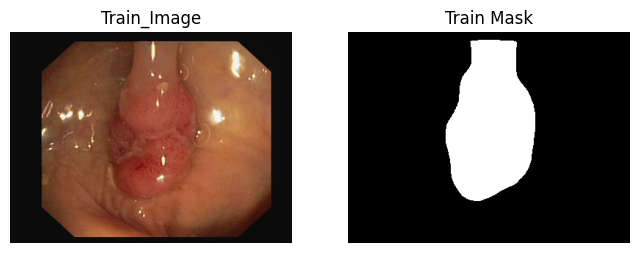

In [8]:
import matplotlib.pyplot as plt

view_image_index = 10

fig, axis = plt.subplots(1, 2, figsize=(8, 4))

img_path = os.path.join(config['train_image_path'], sorted(image_list)[view_image_index])
mask_path = os.path.join(config['train_mask_path'], sorted(mask_list)[view_image_index])

axis[0].imshow(Image.open(img_path))
axis[0].set_title("Train_Image")
axis[0].axis("off")

axis[1].imshow(Image.open(mask_path))
axis[1].set_title("Train Mask")
axis[1].axis("off")

plt.show()



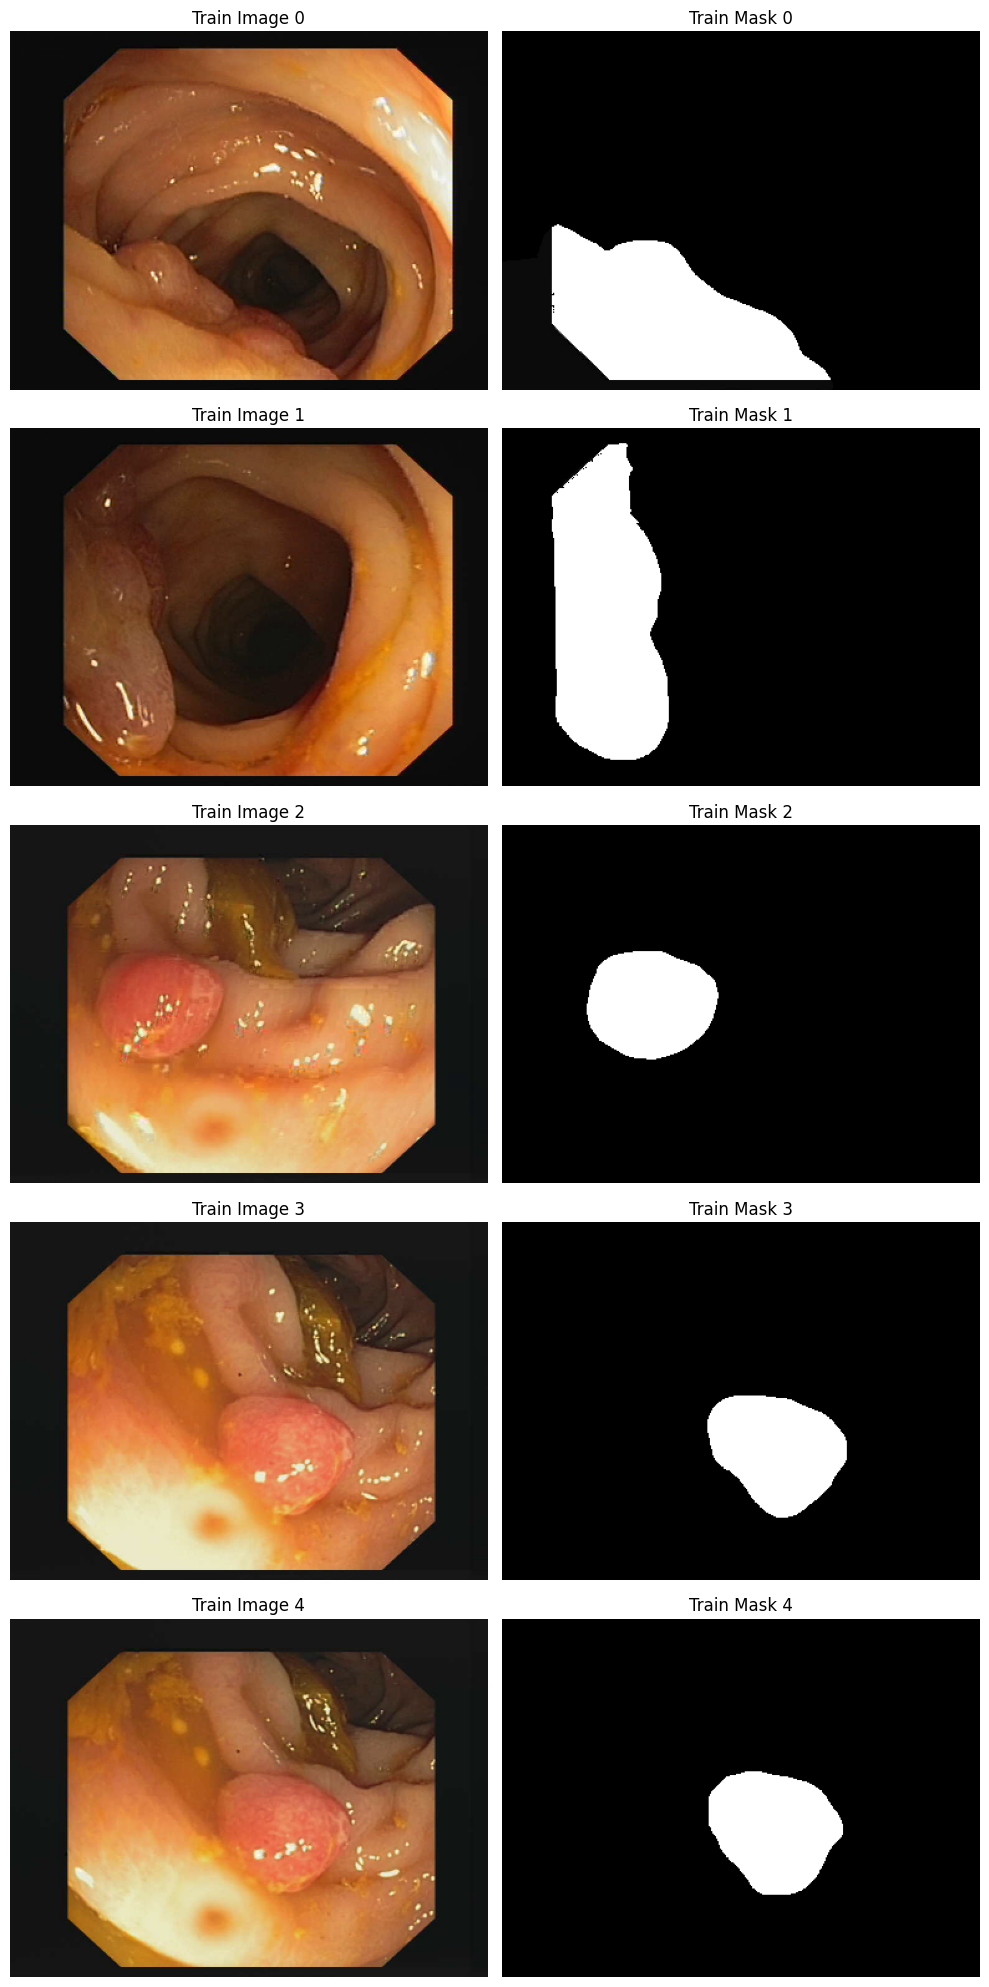

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import os

fig, axis = plt.subplots(5, 2, figsize=(10, 20))

for i in range(5):
    img_path = os.path.join(config['train_image_path'], sorted(image_list)[i])
    mask_path = os.path.join(config['train_mask_path'], sorted(mask_list)[i])

    axis[i, 0].imshow(Image.open(img_path))
    axis[i, 0].set_title(f"Train Image {i}")
    axis[i, 0].axis("off")

    axis[i, 1].imshow(Image.open(mask_path), cmap="gray")
    axis[i, 1].set_title(f"Train Mask {i}")
    axis[i, 1].axis("off")

plt.tight_layout()
plt.show()


In [10]:
def dice_score(preds, targets, smooth=1e-6):
    # preds: (B, H, W), targets: (B, H, W)
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)

    intersection = (preds_flat == targets_flat).float().sum()
    return (2 * intersection + smooth) / (preds_flat.numel() + targets_flat.numel() + smooth)


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MultiResUnet(input_channels=3, num_classes=1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config['learning-rate'])

criterion = torch.nn.BCEWithLogitsLoss()

In [12]:
num_epochs = config['epochs']
best_dice = 0

train_losses = []
val_losses = []
val_dices = []

for epoch in range(num_epochs):
    # -------- TRAIN --------
    model.train()
    train_loss = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).float()

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # -------- VALIDATION --------
    model.eval()
    val_loss = 0
    val_dice = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device).float()

            outputs = model(images)

            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_dice += dice_score(
                preds.squeeze(1), masks.squeeze(1)
            ).item()

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)

    val_losses.append(val_loss)
    val_dices.append(val_dice)

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Dice: {val_dice:.4f}"
    )

    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved Best Model!")


Epoch 1/500 | Train Loss: 0.7372 | Val Loss: 0.6917 | Val Dice: 0.8976
Saved Best Model!
Epoch 2/500 | Train Loss: 0.6972 | Val Loss: 0.6625 | Val Dice: 0.9015
Saved Best Model!
Epoch 3/500 | Train Loss: 0.6633 | Val Loss: 0.6371 | Val Dice: 0.9015
Epoch 4/500 | Train Loss: 0.6411 | Val Loss: 0.6164 | Val Dice: 0.9015
Epoch 5/500 | Train Loss: 0.6167 | Val Loss: 0.6002 | Val Dice: 0.9015
Epoch 6/500 | Train Loss: 0.6024 | Val Loss: 0.5874 | Val Dice: 0.9015
Epoch 7/500 | Train Loss: 0.5882 | Val Loss: 0.5815 | Val Dice: 0.9015
Epoch 8/500 | Train Loss: 0.5782 | Val Loss: 0.5787 | Val Dice: 0.9015
Epoch 9/500 | Train Loss: 0.5683 | Val Loss: 0.5761 | Val Dice: 0.9015
Epoch 10/500 | Train Loss: 0.5610 | Val Loss: 0.5749 | Val Dice: 0.9011
Epoch 11/500 | Train Loss: 0.5559 | Val Loss: 0.5746 | Val Dice: 0.9019
Saved Best Model!
Epoch 12/500 | Train Loss: 0.5486 | Val Loss: 0.5721 | Val Dice: 0.9053
Saved Best Model!
Epoch 13/500 | Train Loss: 0.5445 | Val Loss: 0.5694 | Val Dice: 0.9115
S

500
500
500


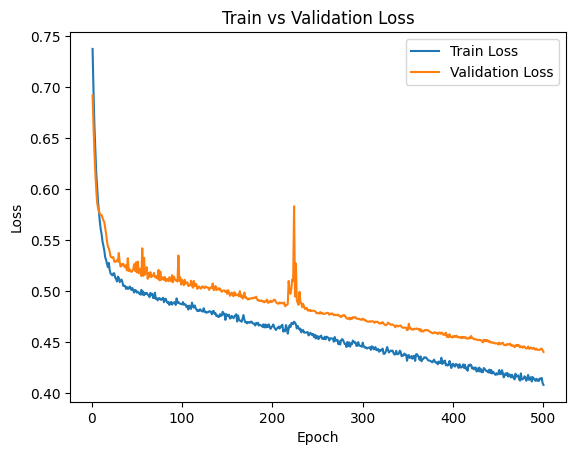

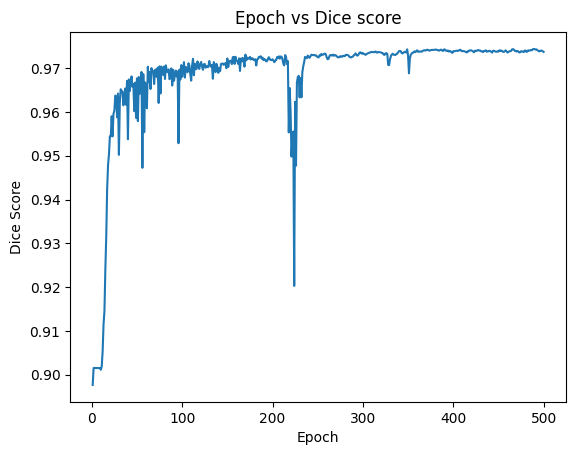

In [13]:
import matplotlib.pyplot as plt

epochs = range(1, config['epochs'] + 1)

plt.figure()

print(len(epochs))
print(len(train_losses))
print(len(val_losses))

plt.plot(epochs, train_losses)
plt.plot(epochs, val_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend(["Train Loss", "Validation Loss"])
plt.show()

plt.plot(epochs, val_dices)
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.title("Epoch vs Dice score")
# plt.legend(["Train Loss", "Validation Loss"])
plt.show()

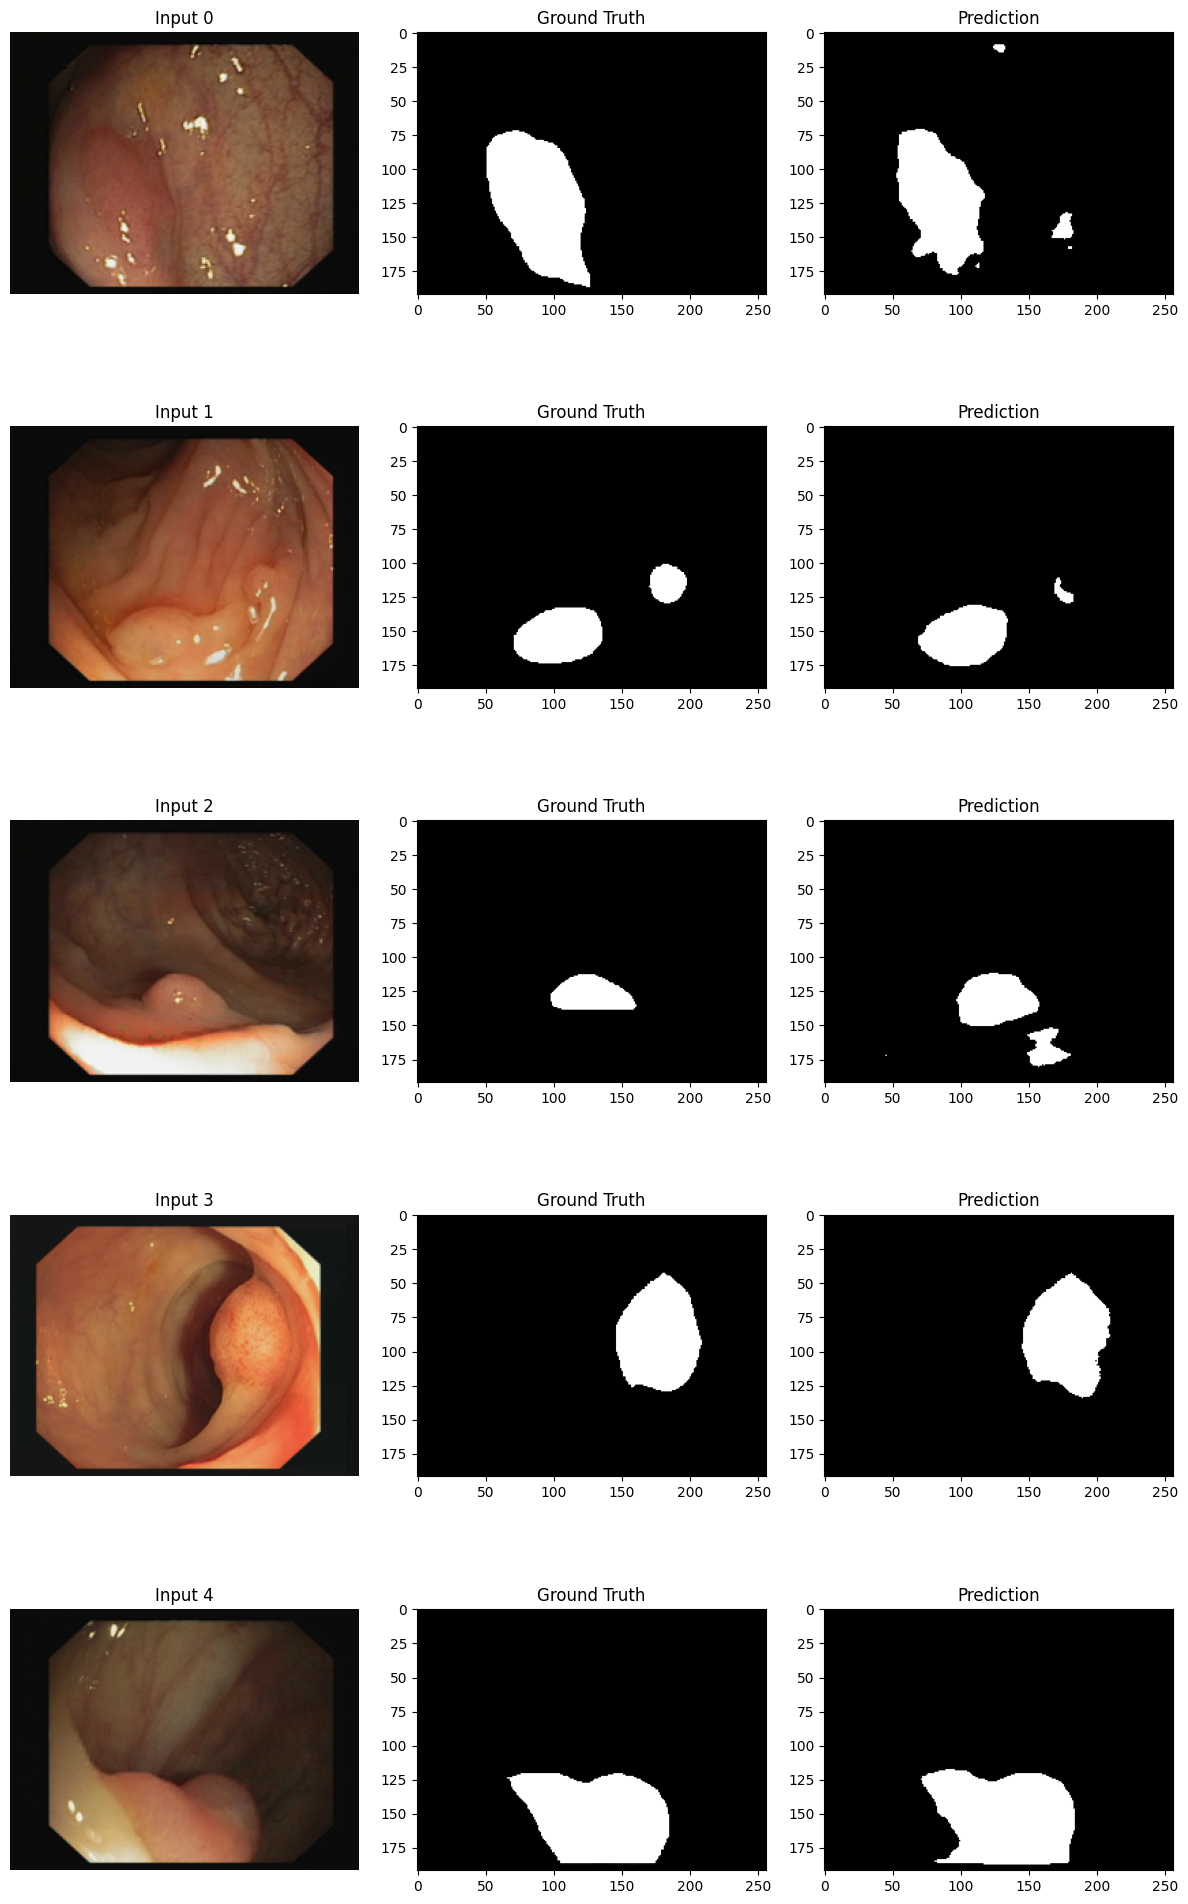

In [14]:
# Load model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Visualize 5 predictions
num_samples = 5
fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))

with torch.no_grad():
    for i in range(num_samples):
        image, mask = val_dataset[i]

        image_batch = image.unsqueeze(0).to(device)
        output = model(image_batch)
        pred = (torch.sigmoid(output) > 0.5).squeeze().cpu().float()

        # Plot
        axes[i, 0].imshow(image.permute(1, 2, 0).numpy())
        axes[i, 0].set_title(f'Input {i}')
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask.squeeze().numpy(), cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 0].axis("off")


        axes[i, 2].imshow(pred.numpy(), cmap='gray')
        axes[i, 2].set_title('Prediction')
        axes[i, 0].axis("off")


plt.tight_layout()
plt.show()